In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import osmnx as ox

### 1. Load isochrone polygon files as base

In [2]:
# import rail isochrones
rail_isochrone = gpd.read_file(os.path.join('data','cleaned','rail_isochrone_15m.gpkg'),crs='EPSG:27700')
rail_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   400 non-null    int64   
 1   name      400 non-null    object  
 2   pt_type   400 non-null    object  
 3   geometry  400 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 12.6+ KB


In [3]:
# import bus isochrones
bus_isochrone = gpd.read_file(os.path.join('data','cleaned','bus_isochrone_15m.gpkg'),crs='EPSG:27700')
bus_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   18526 non-null  object  
 1   name      18526 non-null  object  
 2   pt_type   18526 non-null  object  
 3   geometry  18526 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 579.1+ KB


### 2. Prep TARGET VARIABLE

In [4]:
# Merge with BUSTO data
flow_bus = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStop_.gpkg'))
flow_bus.STOPCODE = flow_bus.STOPCODE.astype(str)
# # merge with pt_isochrone pt_type bus
bus_isochrone_merge = bus_isochrone[['id_code','name','pt_type','geometry']].merge(flow_bus[['STOPCODE',
                                            'Early',
                                            # 'AM Peak',
                                            # 'Midday',
                                            # 'PM Peak',
                                            # 'Evening',
                                            # 'Late',
                                            'Total']],left_on='id_code',right_on='STOPCODE',how='left').drop('STOPCODE',axis=1)

# Sample dataset does not have other timebands for now -> insert dummy columns
bus_isochrone_merge['AM Peak'] = 0
bus_isochrone_merge['Midday'] = 0
bus_isochrone_merge['PM Peak'] = 0
bus_isochrone_merge['Evening'] = 0
bus_isochrone_merge['Late'] = 0

bus_isochrone_merge.fillna(0,inplace=True)
bus_isochrone_merge.tail()

id_code               name pt_type  \
18521     W46     Morden Station     bus   
18522     W48     Morden Station     bus   
18523      W5     Tilford Avenue     bus   
18524      W6     Betchworth Way     bus   
18525      W7  Hawthorn Crescent     bus   

                                                geometry  Early  Total  \
18521  POLYGON ((525131.464 168498.164, 525128.975 16...    0.0    0.0   
18522  POLYGON ((525167.420 168428.957, 525166.683 16...    0.0    0.0   
18523  POLYGON ((538135.409 162802.982, 538132.965 16...    0.0    0.0   
18524  POLYGON ((537981.848 162704.382, 537981.152 16...    0.0    0.0   
18525  POLYGON ((535091.077 160434.826, 535090.557 16...    0.0    0.0   

       AM Peak  Midday  PM Peak  Evening  Late  
18521        0       0        0        0     0  
18522        0       0        0        0     0  
18523        0       0        0        0     0  
18524        0       0        0        0     0  
18525        0       0        0        0     0

In [5]:
flow_rail = gpd.read_file(os.path.join('data','cleaned','flow_rail.gpkg'))
flow_rail.nlc = flow_rail.nlc.astype(str)
rail_isochrone.id_code = rail_isochrone.id_code.astype(str)
# merge with pt_isochrone pt_type bus
rail_isochrone_merge = rail_isochrone[['id_code','name','pt_type','geometry']].merge(flow_rail[['nlc',
                                            'Early',
                                            'AM Peak',
                                            'Midday',
                                            'PM Peak',
                                            'Evening',
                                            'Late',
                                            'Total']],left_on='id_code',right_on='nlc',how='left').drop('nlc',axis=1)

rail_isochrone_merge.tail()

id_code              name pt_type  \
395     769          Woodford    rail   
396    7467   Woodgrange Park    rail   
397     771     Woodside Park    rail   
398     573  Woolwich Arsenal    rail   
399    6562       Woolwich EL    rail   

                                              geometry  Early  AM Peak  \
395  POLYGON ((540120.303 191243.491, 540118.409 19...     59      330   
396  POLYGON ((540916.722 185139.068, 540916.714 18...     14      130   
397  POLYGON ((524968.245 191502.198, 524965.791 19...     21      304   
398  POLYGON ((543232.261 178644.520, 543230.081 17...    479     1644   
399  POLYGON ((543466.165 178853.764, 543465.578 17...    114      906   

     Midday  PM Peak  Evening  Late  Total  
395    1711     1457     1015   730   5301  
396     395      272      181    98   1090  
397    1492     1525     1137   917   5396  
398    4295     2706     1830  1366  12320  
399    4559     3699     2888  1847  14013

In [6]:
#concatenate into one dataset

col = ['id_code','pt_type','geometry','Early', 'AM Peak','Midday','PM Peak','Evening','Late','Total']
pt_isochrone = pd.concat([
                            rail_isochrone_merge[col],
                            bus_isochrone_merge[col]
                            ])
pt_isochrone.reset_index(inplace=True, drop=True)

pt_isochrone.id_code = pt_isochrone.id_code.astype(str)
pt_isochrone['Early'] = pt_isochrone['Early'].astype(int) # unify to integer
pt_isochrone['Total'] = pt_isochrone['Total'].astype(int) # unify to integer

pt_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18926 entries, 0 to 18925
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   18926 non-null  object  
 1   pt_type   18926 non-null  object  
 2   geometry  18926 non-null  geometry
 3   Early     18926 non-null  int32   
 4   AM Peak   18926 non-null  int64   
 5   Midday    18926 non-null  int64   
 6   PM Peak   18926 non-null  int64   
 7   Evening   18926 non-null  int64   
 8   Late      18926 non-null  int64   
 9   Total     18926 non-null  int32   
dtypes: geometry(1), int32(2), int64(5), object(2)
memory usage: 1.3+ MB


#### Plot 

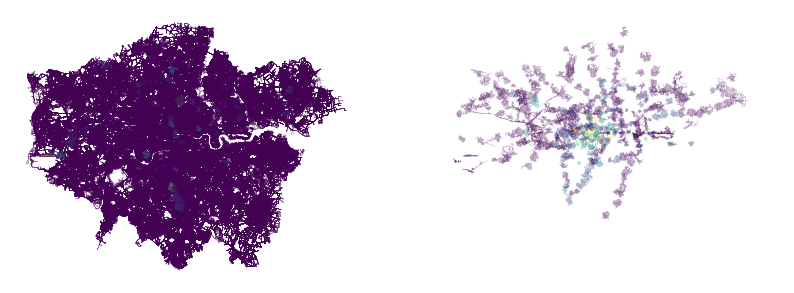

In [7]:
# plot them
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
pt_isochrone[pt_isochrone.pt_type=='bus'].plot(ax=ax[0], column='Total', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
pt_isochrone[pt_isochrone.pt_type=='rail'].plot(ax=ax[1], column='Total', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### 3. Prep FEATURES
#### 3.1 Aggregate intersecting Population and POI density

In [8]:
# import poi_pop_h3 file
poi_pop_h3 = gpd.read_file(os.path.join('data','cleaned','poi_pop_h3_r10.gpkg'))
poi_pop_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   h3                     116586 non-null  object  
 1   population             116586 non-null  int64   
 2   poi_banking            116586 non-null  float64 
 3   poi_hotels             116586 non-null  float64 
 4   poi_leisure_active     116586 non-null  float64 
 5   poi_leisure_nightlife  116586 non-null  float64 
 6   poi_leisure_outdoor    116586 non-null  float64 
 7   poi_medical            116586 non-null  float64 
 8   poi_nature             116586 non-null  float64 
 9   poi_public_facilities  116586 non-null  float64 
 10  poi_religious          116586 non-null  float64 
 11  poi_restaurants        116586 non-null  float64 
 12  poi_shopping           116586 non-null  float64 
 13  poi_tourism            116586 non-null  float64 
 14  transport_bu

In [9]:
%%time
# takes 1hr
df_ml = pt_isochrone.copy()

# for each isochrone, calculate the values from poi_pop_h3 intersecting it 
for i, row in df_ml.iterrows():
    intersect = poi_pop_h3[poi_pop_h3.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry
    for col in intersect.columns[1:-1]: 
        value = intersect[col].sum()
        df_ml.at[i, col] = round(value)

df_ml.head()

#### 3.2 Calculate POI diversity - Shannon entropy within each isochrone

In [ ]:
# Load borough shapefile for Islington borough using osmnx
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

In [ ]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calc_poi_entropy(row):

    # get the values of the row only for columns whose name contain poi_
    c = row.filter(like='poi_').values.astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml['diversity_poi'] = df_ml.apply(calc_poi_entropy, axis=1)

<Axes: title={'center': 'Top 10% POI diversity'}>

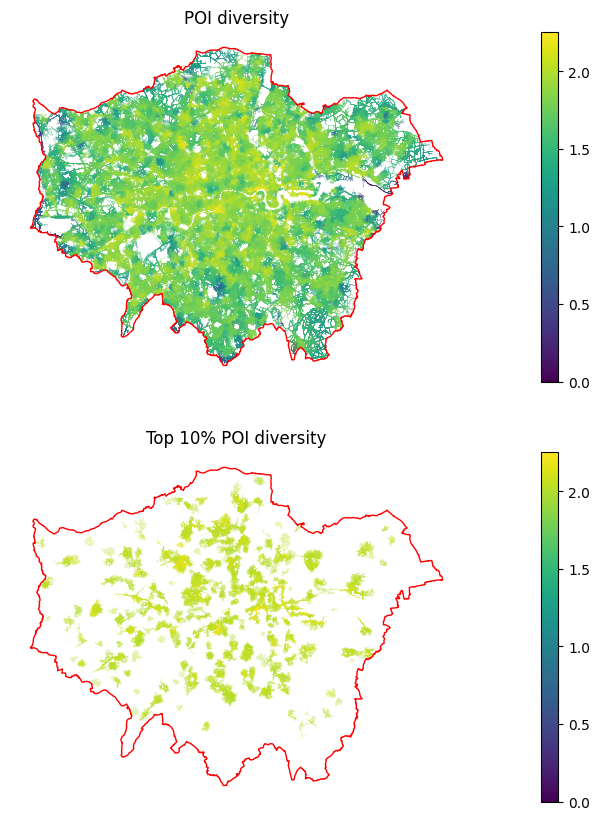

In [ ]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml.diversity_poi.min()
vmax = df_ml.diversity_poi.max()

df_ml.plot(column='diversity_poi', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('POI diversity')
ax[0].axis('off')

df_ml[df_ml.diversity_poi > df_ml.diversity_poi.quantile(0.90)].plot(
            column='diversity_poi', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% POI diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

#### 3.3 Calculate Transport node diversity - Shannon entropy within each isochrone

In [ ]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calc_transport_entropy(row):
    # get the values of the row only for columns whose name contain poi_
    c = row.filter(like='transport_').values.astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml['diversity_transport'] = df_ml.apply(calc_transport_entropy, axis=1)

<Axes: title={'center': 'Top 10% PT mode diversity'}>

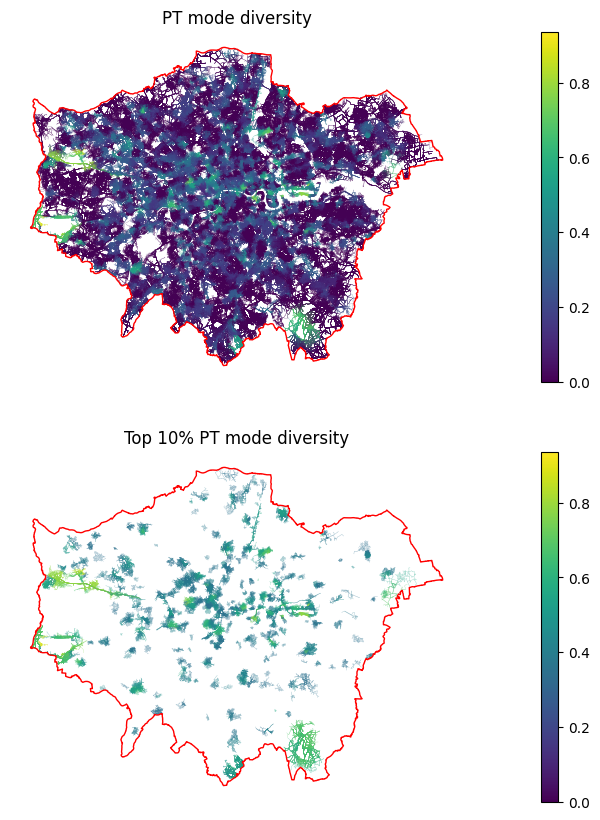

In [ ]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml.diversity_transport.min()
vmax = df_ml.diversity_transport.max()

df_ml.plot(column='diversity_transport', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('PT mode diversity')
ax[0].axis('off')

df_ml[df_ml.diversity_transport > df_ml.diversity_transport.quantile(0.90)].plot(
            column='diversity_transport', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% PT mode diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

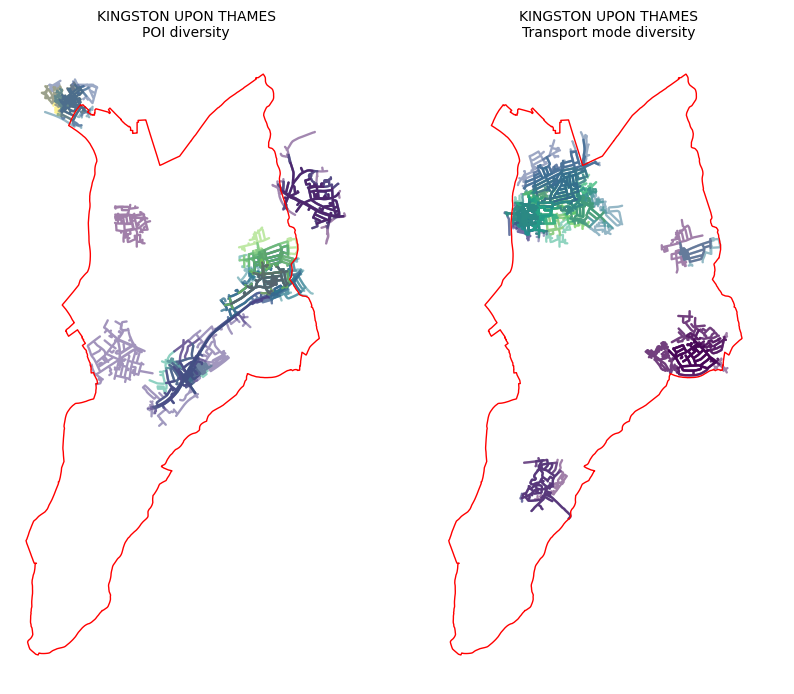

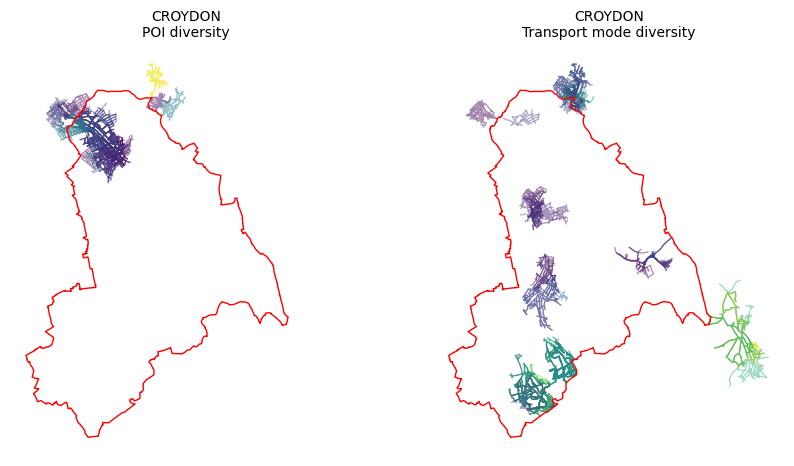

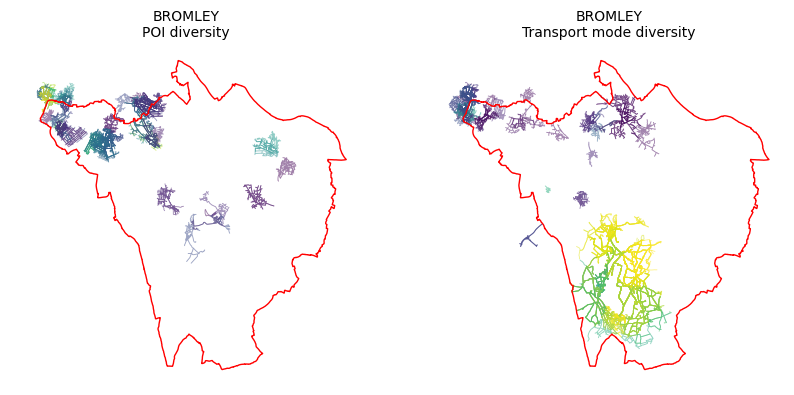

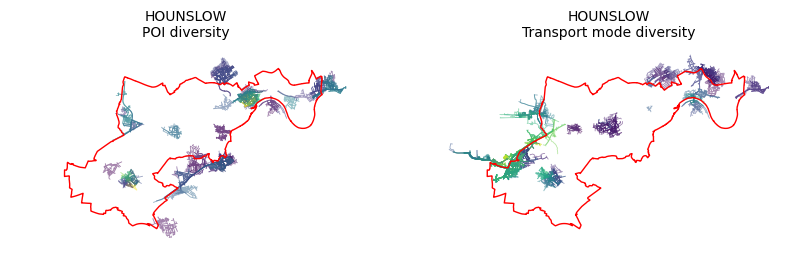

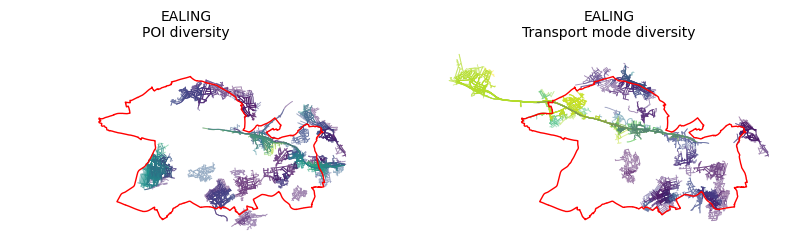

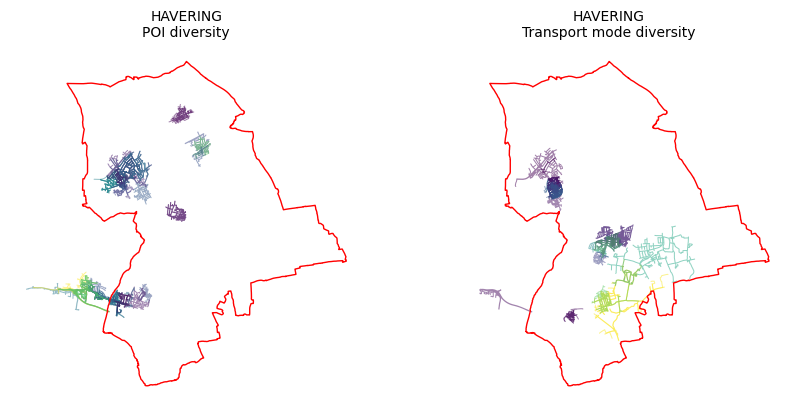

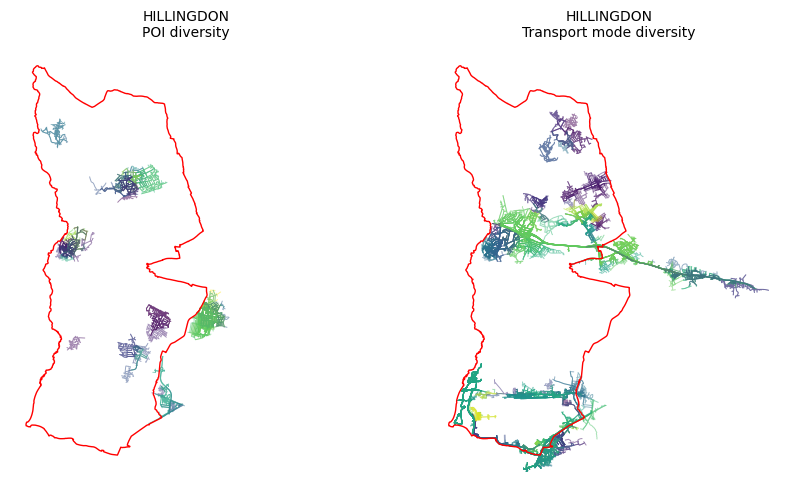

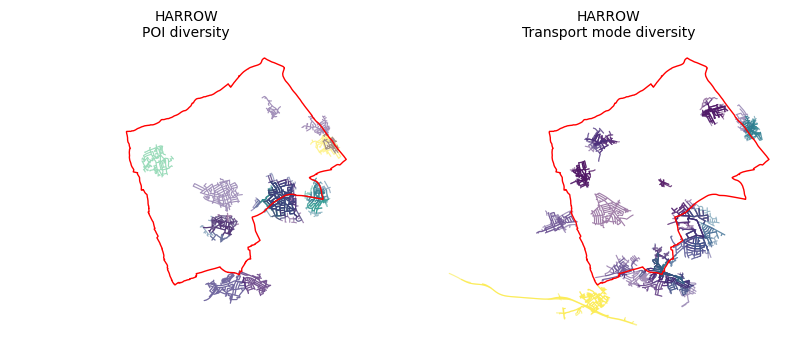

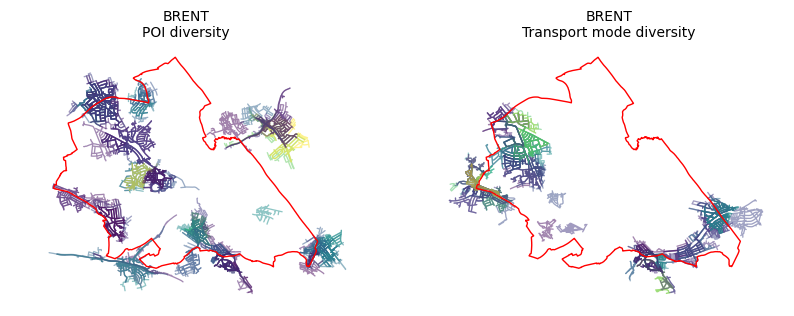

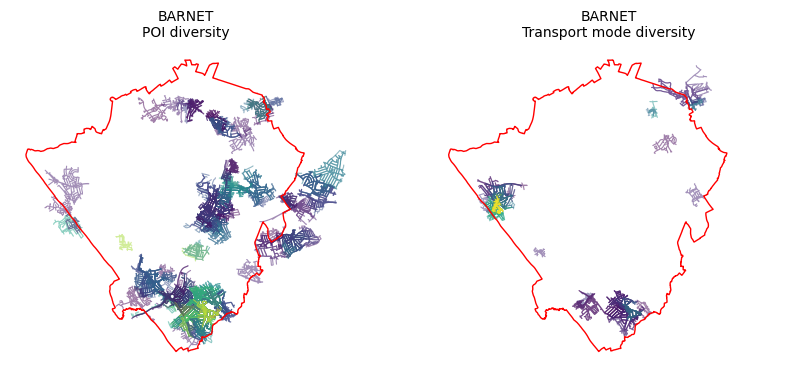

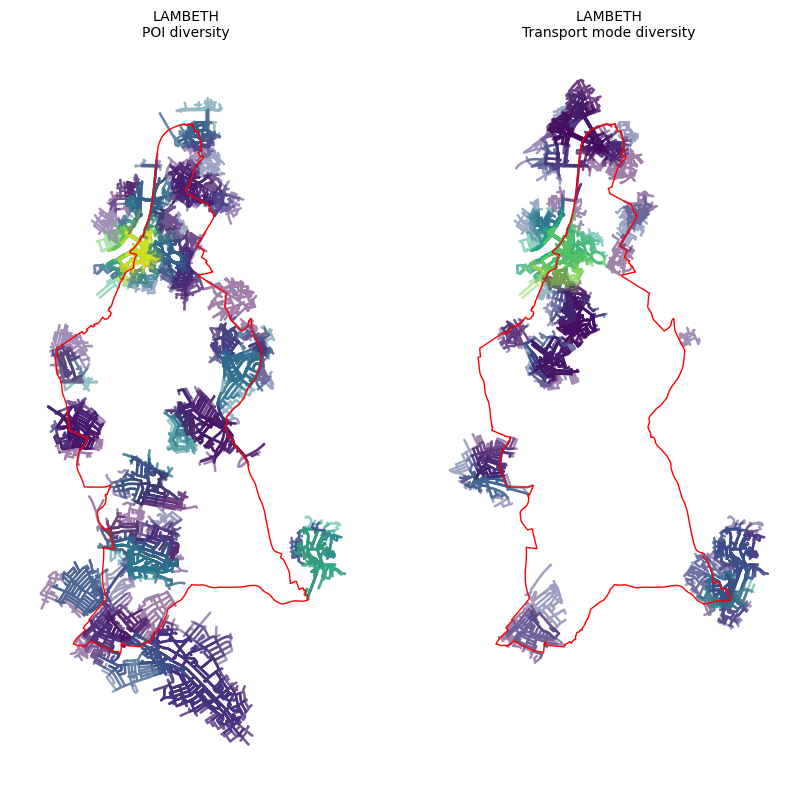

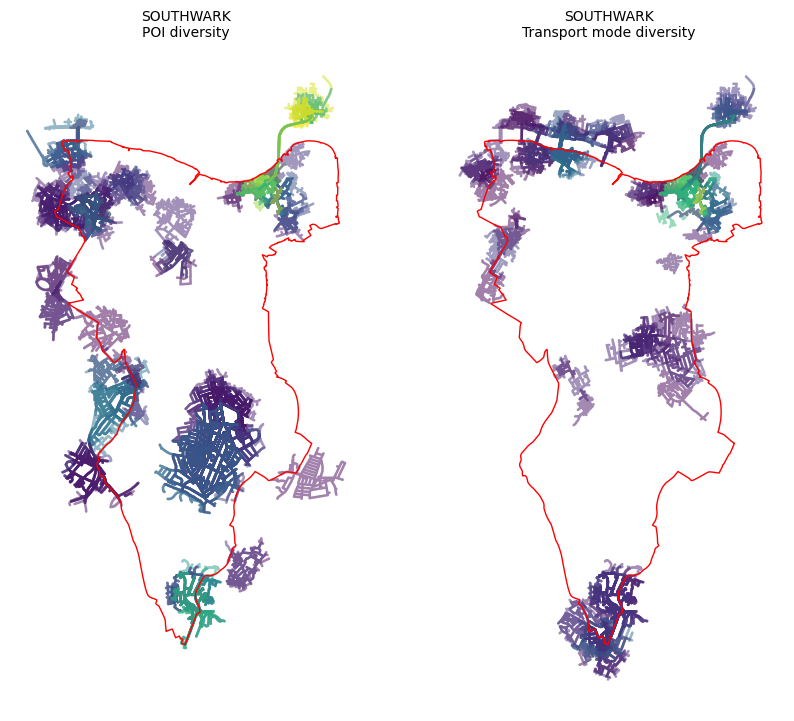

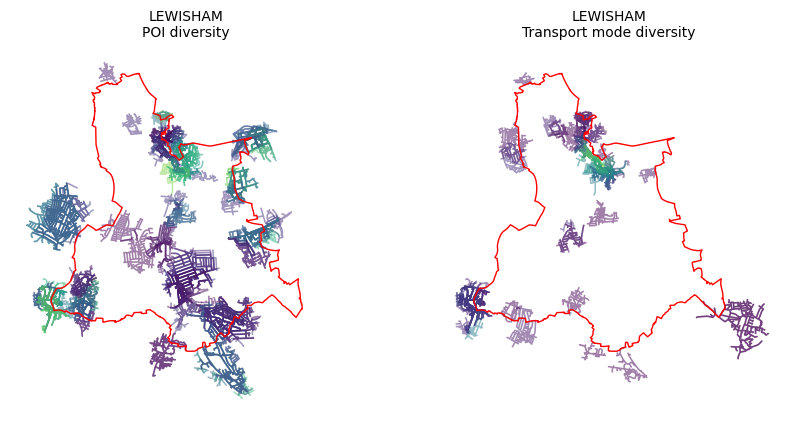

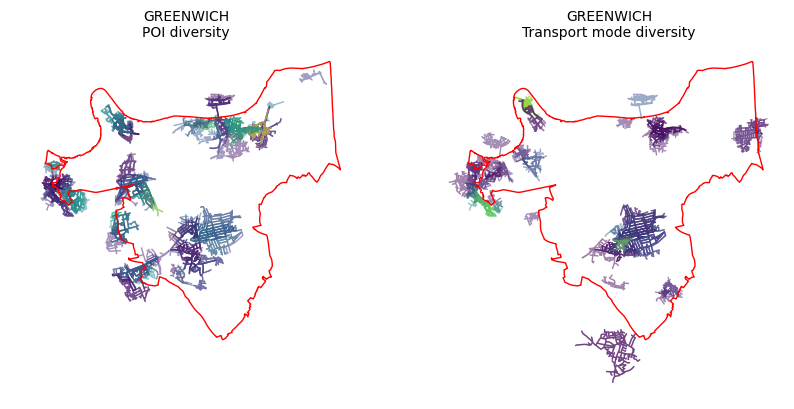

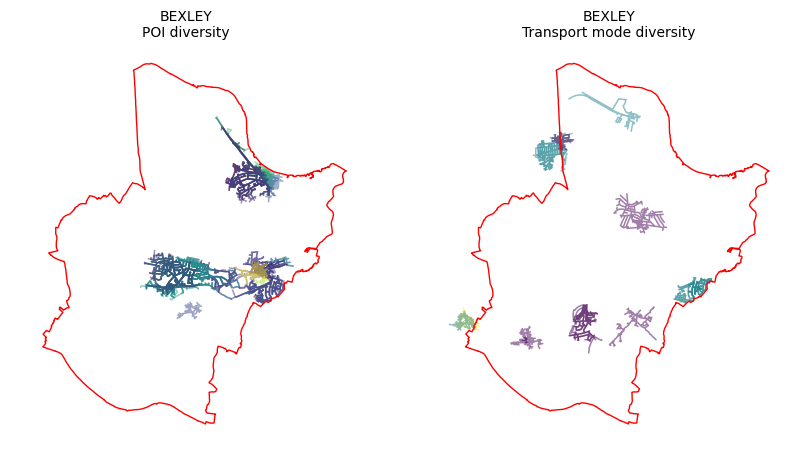

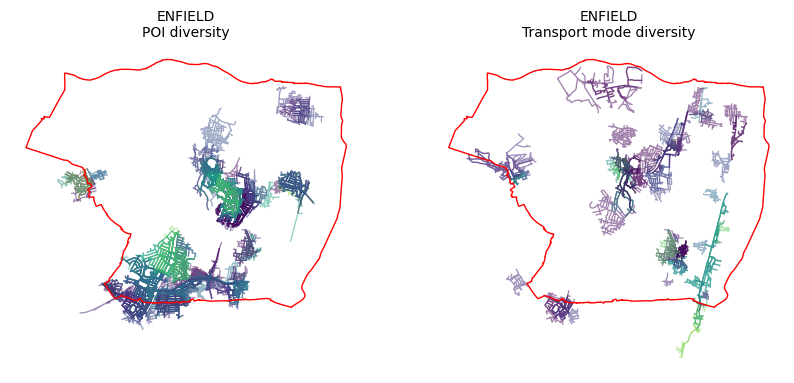

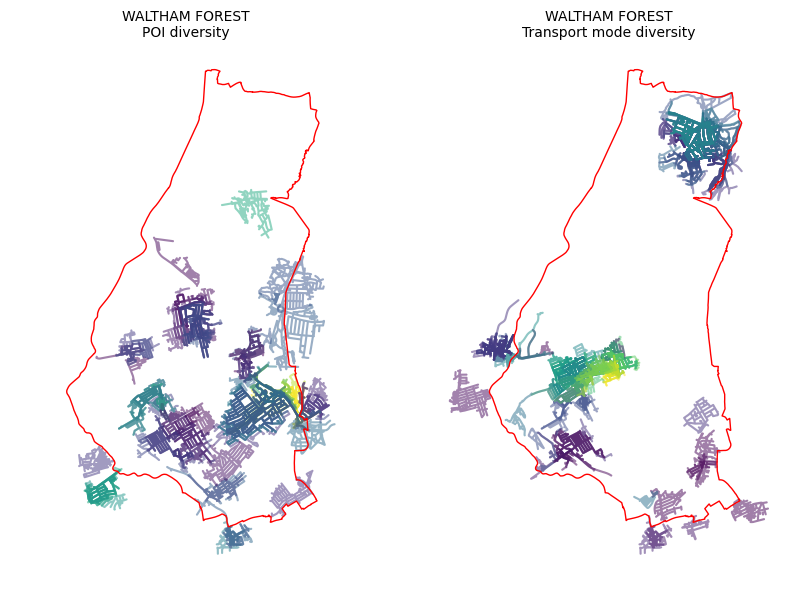

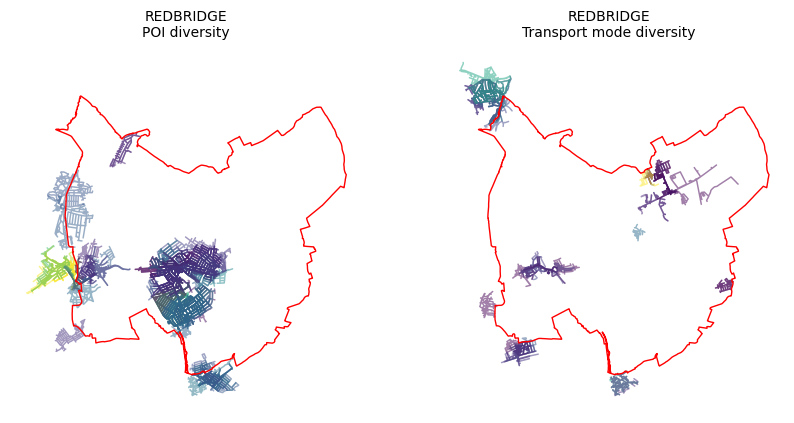

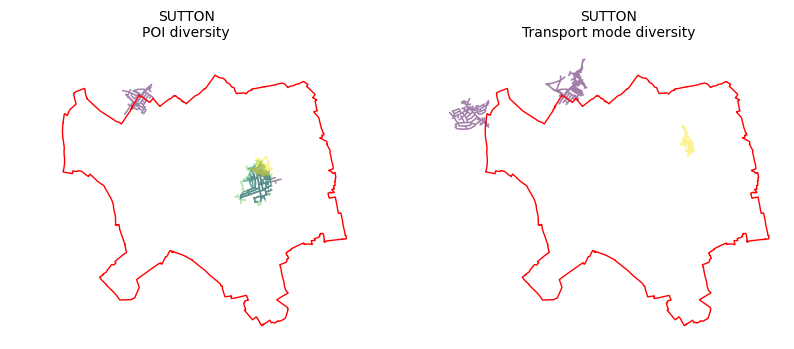

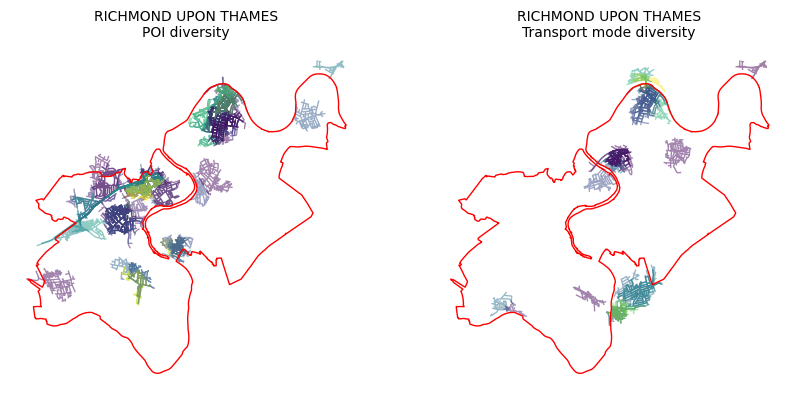

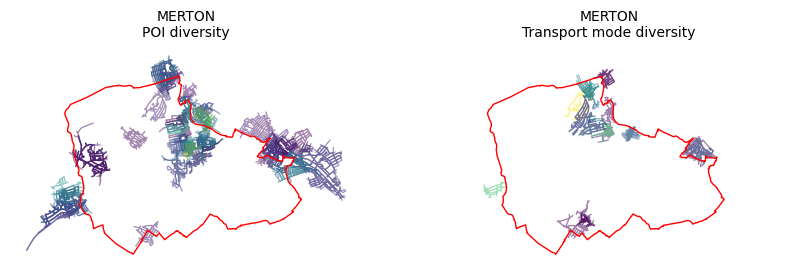

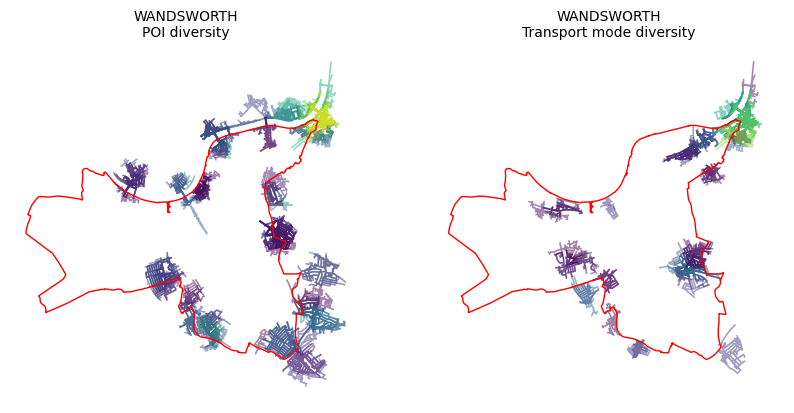

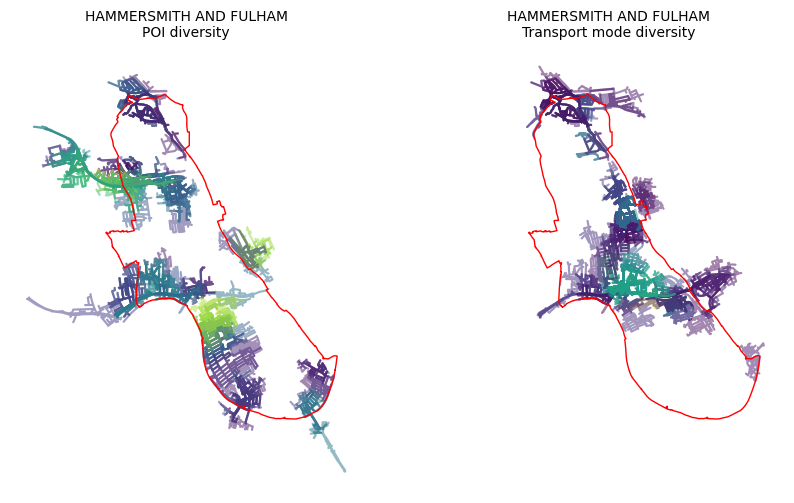

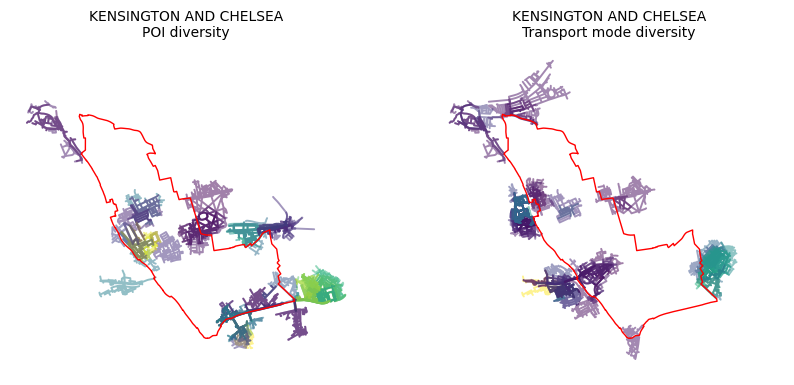

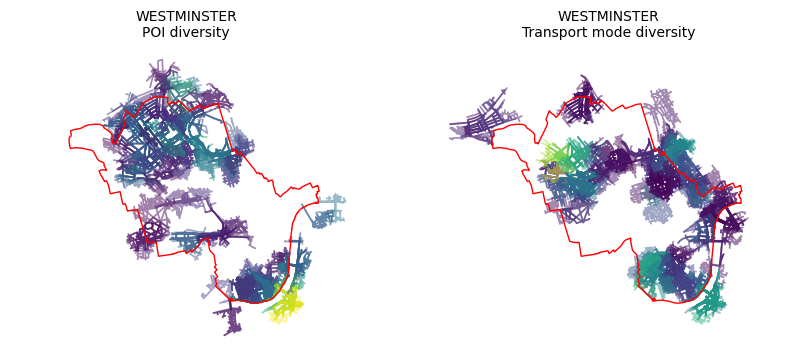

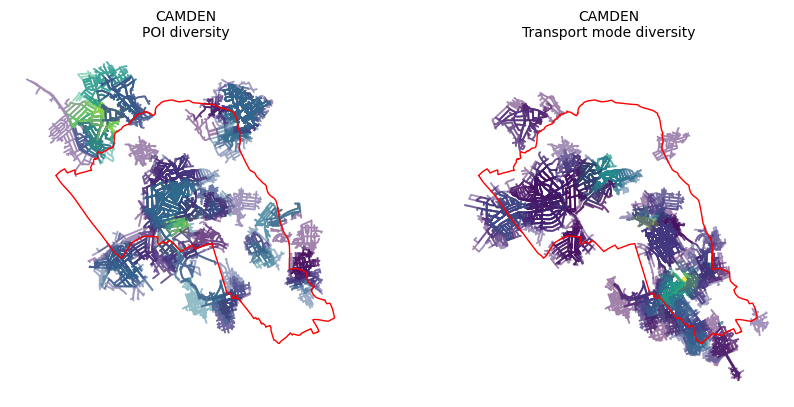

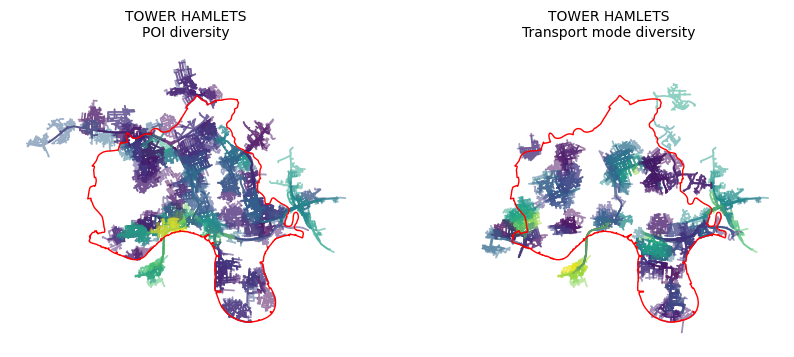

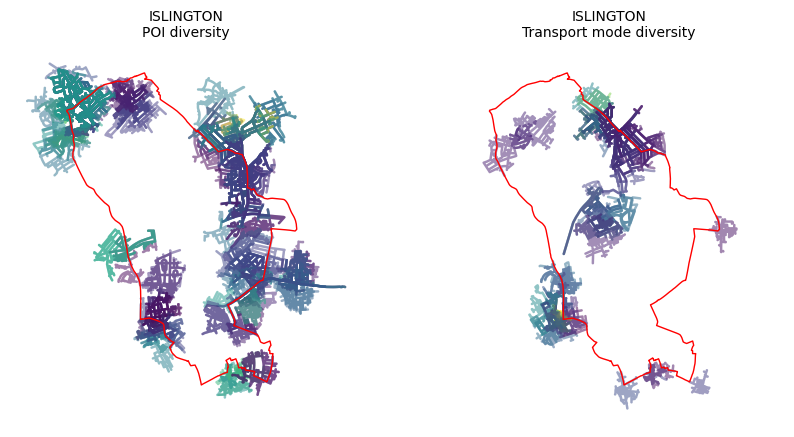

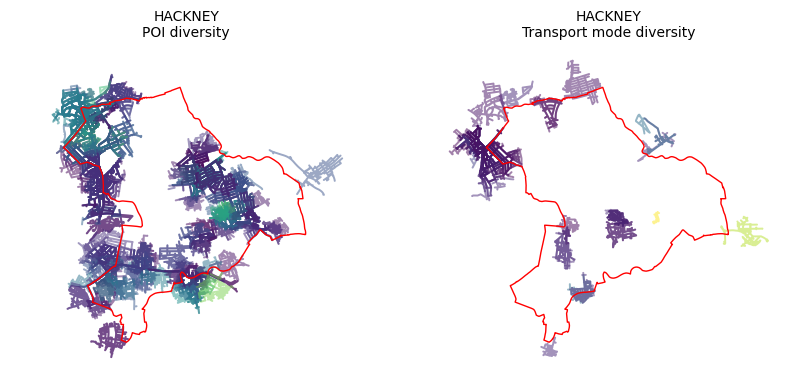

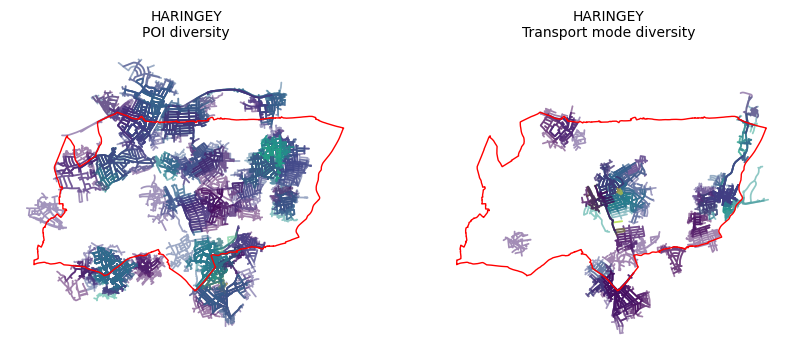

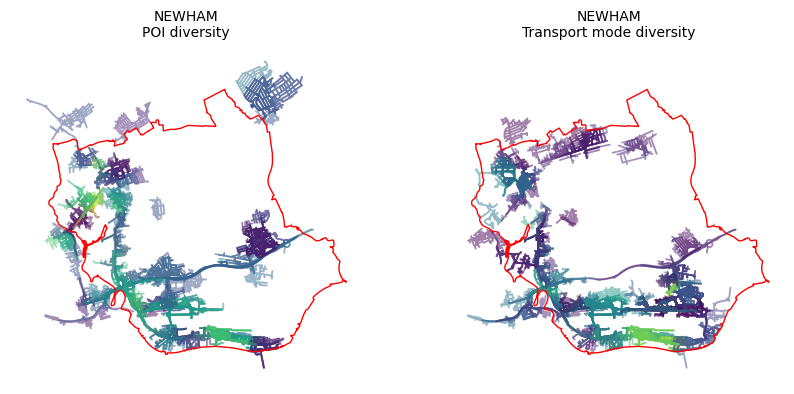

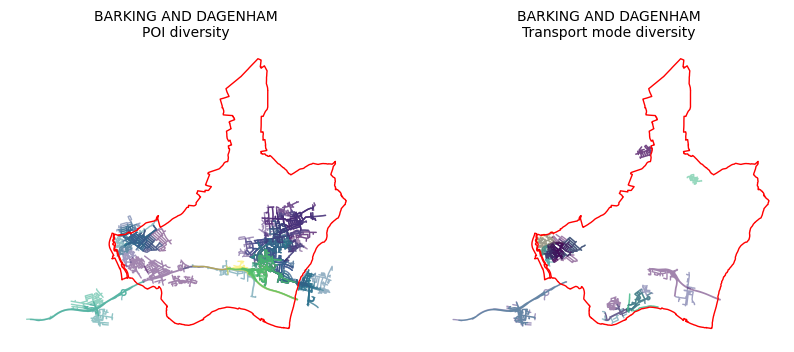

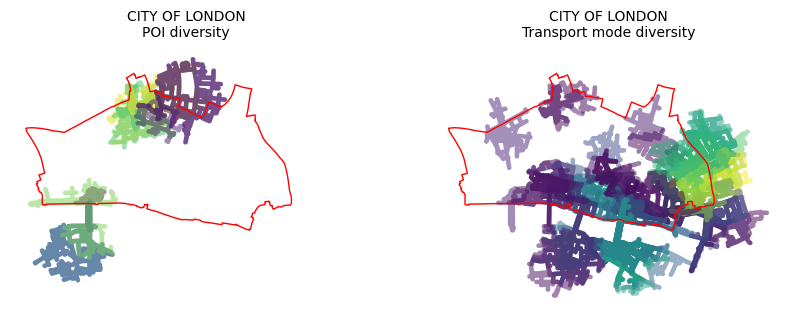

In [ ]:
# for each boro in boro geodataframe, plot both diversity maps
for boro in boros.iterrows():
    fig, ax = plt.subplots(1,2,sharex=True, sharey=True,figsize=(10,10))
    boro_name = boro[1].NAME
    boro_geom = boro[1].geometry
    
    df_plot = df_ml[df_ml.diversity_transport > df_ml.diversity_transport.quantile(0.90)] 
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transport',
        ax=ax[1],
        legend=False,
        alpha=0.5,
        cmap='viridis'
    )
    ax[1].axis('off')
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title(f'{boro_name.upper()}\nTransport mode diversity', fontsize=10)

    df_plot = df_ml[df_ml.diversity_poi > df_ml.diversity_poi.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_poi',
        ax=ax[0],
        legend=False,
        alpha=0.5,
        cmap='viridis'
    )
    ax[0].axis('off')
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title(f'{boro_name.upper()}\nPOI diversity', fontsize=10)

    boros[boros.NAME == boro_name].boundary.plot(ax=ax[0], color='red', linewidth=1)
    boros[boros.NAME == boro_name].boundary.plot(ax=ax[1], color='red', linewidth=1)

    plt.savefig(os.path.join('output','div',f'div_{boro_name}.png'))
    plt.show()

    # uppercase string



#### 3.3 Aggregate centrality measures (max_rail, max_bus, combined) for each isochrone

### 4. Export to file

In [156]:
df_ml.to_file(os.path.join('data','cleaned','df_ml.gpkg'), driver='GPKG')
# Aggregated up until 3.2